In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from test_utils import summary
print(tf.__version__)

In [ ]:
#1024 refers to full size input images
#segmenter granules 1024b (8/23/2023) includes a randomContrast layer
#1024C includes prediction of test images, still in dataset mode

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import imageio.v2 as imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, 'C:/Users/erios/EM_Images/split_random_granules_train/')
mask_path = os.path.join(path, 'C:/Users/erios/EM_Images/split_random_granules_labels/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in mask_list_orig]
print(image_list[0:1])
print(mask_list[0:1])

['C:/Users/erios/EM_Images/split_random_granules_train/0000.png']
['C:/Users/erios/EM_Images/split_random_granules_labels/0000Labeling.png']


In [3]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(1), mask_list_ds.take(1)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\erios\\EM_Images\\split_random_granules_train\\0000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\erios\\EM_Images\\split_random_granules_labels\\0000Labeling.png'>)


In [5]:
 
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'C:/Users/erios/EM_Images/split_random_granules_train/0000.png', shape=(), dtype=string)
tf.Tensor(b'C:/Users/erios/EM_Images/split_random_granules_labels/0000Labeling.png', shape=(), dtype=string)


In [53]:
seed = (1, 2)
ran = tf.keras.layers.RandomContrast(0.9)
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=0, dtype=tf.dtypes.uint16)
    #mask = tf.cast(mask, tf.uint8)
    return img, mask

def preprocess(image, mask):
    global seed
    seed = (seed[0] + random.randint(0, 10000), seed[1] + random.randint(0, 10000))
    #changes the seed randomly
    input_image = tf.image.resize(image, (1024,1024), method='nearest')
    input_mask = tf.image.resize(mask, (1024,1024), method='nearest')
    input_image = tf.image.stateless_random_flip_left_right(input_image, seed)
    input_mask = tf.image.stateless_random_flip_left_right(input_mask, seed)
    input_image = tf.image.stateless_random_flip_up_down(input_image, seed)
    input_mask = tf.image.stateless_random_flip_up_down(input_mask, seed)
    input_image = ran(input_image)
    input_image = tf.image.random_brightness(input_image, 0.25)
    return input_image, input_mask

#image_ds = dataset.map(process_path)
#processed_image_ds = image_ds.map(preprocess)


In [139]:
# validation only  
path= ''
image_path_val = os.path.join(path, 'C:/Users/erios/EM_Images/split_random_granules_val/')
mask_path_val = os.path.join(path, 'C:/Users/erios/EM_Images/split_random_granules_val_labels/')
image_list_orig_val = os.listdir(image_path_val)
mask_list_orig_val = os.listdir(mask_path_val)
image_list_val = [image_path_val+i for i in image_list_orig_val]
mask_list_val = [mask_path_val+i for i in mask_list_orig_val]
print(image_list_val[0:1])
print(mask_list_val[0:1])

['C:/Users/erios/EM_Images/split_random_granules_val/0090.png']
['C:/Users/erios/EM_Images/split_random_granules_val_labels/0090Labeling.png']


In [140]:
# validation only
image_list_ds_val = tf.data.Dataset.list_files(image_list_val, shuffle=False)
mask_list_ds_val = tf.data.Dataset.list_files(mask_list_val, shuffle=False)

for path in zip(image_list_ds_val.take(1), mask_list_ds_val.take(1)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\erios\\EM_Images\\split_random_granules_val\\0090.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\erios\\EM_Images\\split_random_granules_val_labels\\0090Labeling.png'>)


In [147]:
# validation only
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=0, dtype=tf.dtypes.uint16)
    return img, mask

def preprocess_val(image, mask):
    input_image = tf.image.resize(image, (1024,1024), method='nearest')
    input_mask = tf.image.resize(mask, (1024,1024), method='nearest')
    return input_image, input_mask

image_ds = dataset_val.map(process_path)
processed_image_ds_val = image_ds.map(preprocess_val)


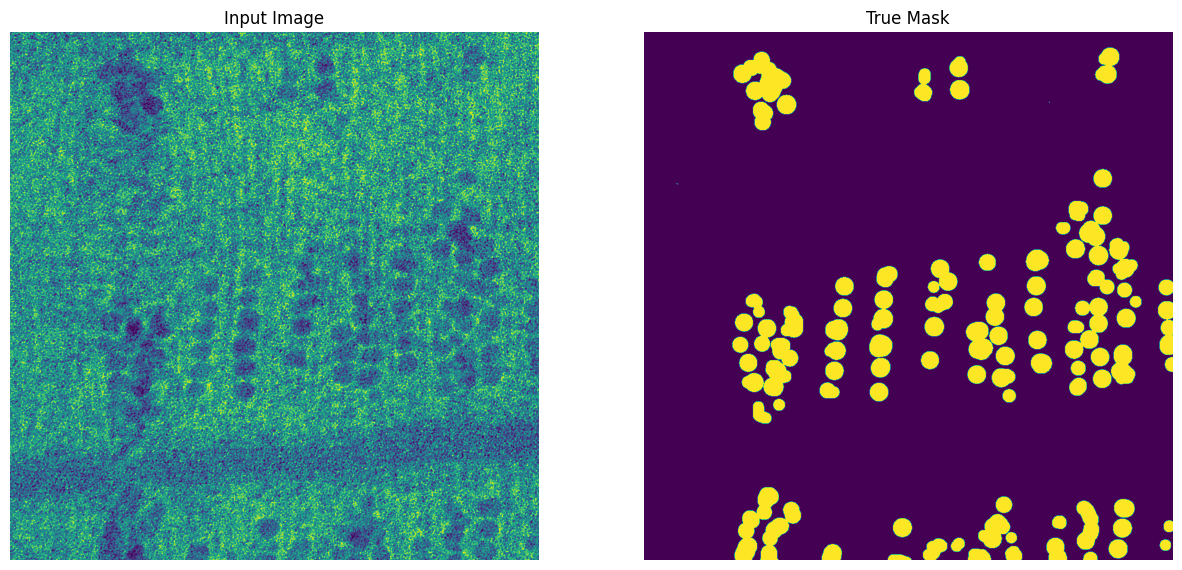

In [148]:
for image, mask in processed_image_ds_val.take(3):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

1/1 [==============================] - 0s 283ms/step


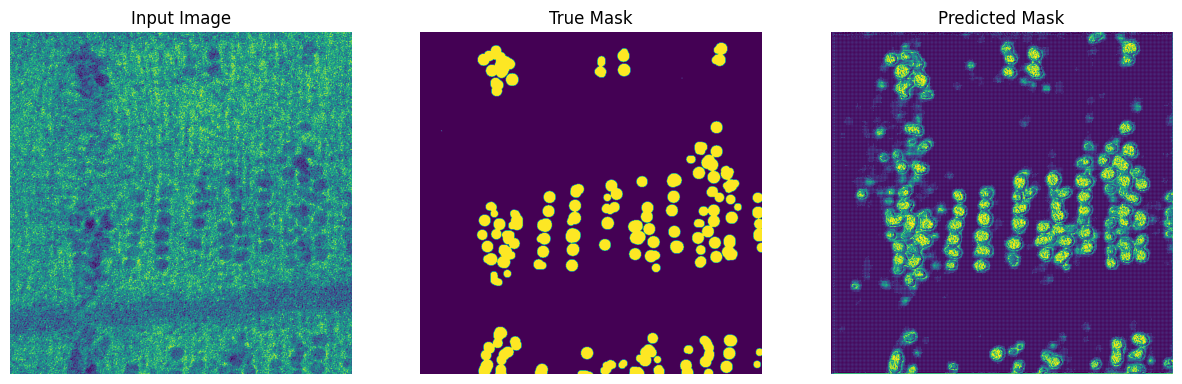

In [244]:
display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [154]:
#demo cells filename

In [255]:
# output to graphics file (ping) of single image
predicted_mask_ping = tf.image.encode_png(predicted_mask)
with open('D:/manuscripts and papers/Methods Manuscript Revision/test_predicted_mask.png', 'wb') as f:
  f.write(predicted_mask_ping.numpy())
with open('D:/manuscripts and papers/Methods Manuscript Revision/test_predicted_mask.png', 'wb') as f:
  f.write(predicted_mask_ping.numpy())

In [264]:
print(type(predicted_mask_ping.numpy()))
type(predicted_mask_ping)


<class 'bytes'>


tensorflow.python.framework.ops.EagerTensor

In [266]:
predicted_mask_ping.numpy()


b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x04\x00\x10\x00\x00\x00\x00\n\xe6\xa8\x1c\x00\x00 \x00IDATx\x9c\xec]\xed\xda\xab,\xaf\x84\xe7\xdd\xe7\x7f\xca\xee\x1f]\xdc\x99\x99$\xa8\xadV\xdbf\xd6\xd5\x85"\x1f\x01B\x08\tz\xb7\xf6@oM\xae\xf6\x86\x9a?\xbb_\xabgk9\xd1\xbd\x95\xd5\xff\xdd\xf7\x7fq\x9d\xd2w\xf9\xcd\xe8y5\xdcBo\xfb\xa3W\xe93\xea\xb5\x1dW\xd0\x1b\xdd\xdf\xad\xfc\xa3\xda\xcfq:>\xc6_x\x7f\xc4\xf8h\xdd\xcf\xf4\x9f\xe7\xed\x98\xfeW\xeb\xf7\xfcjOy\xfe\xad\xf1\x7f\x9e?\xa2\x17\xefcz\xb2\xf1\xf2\xf4\xbe{\xfe\x1c\xcd\x0fk\xe9\xd6\xe8\xc1{\x1f\xd7\xe9\xcaz\xd1\xf7\xa4\xff7\xe7\xb3W\xe5\x03\xc7\xc5\xfc\x92\xc9\x7fmo>?\xe6\xfc\xfb\xceP\xeb\xdd{\x1f\xf5_\x16[(\x14\n\x85B\x80\xfe\xf7\xbf.\xab\x1d\xfe/|\x02\xfa\x7fWSP(\x14\n\x85\x8f\x80\xed\'\x97\xd6[\xfb\xf7\xff#FU\x82R\x04\xee\x8f\x05\x15\x80\xfeV\r.\xabe\x8f\xc9%7\xe1\xc5\xc6\xaa\xb5\xfc\xb3\xf4k\xf4\xad\xb5c^\xbf\xd2\xbbv\xbfN\xc3V:\x9f\xa1\xfb\xce\xe5k=\xc7\xd0\xa5\xa6\xc0\xf8~\x8d\x9f\xd6\xf8qo\xb8\xbd\xbeu~:\xf6\xfe\x

In [207]:
#print(sample_mask.shape, pred0.shape)
#s_mask = (tf.squeeze(sample_mask))
#s_pred1 = (tf.squeeze(pred1))
#print(s_mask.shape, s_pred0.shape)
#loss = np.mean(tf.keras.losses.binary_crossentropy(s_pred0, s_pred1))
#assert loss.shape == (2,)
#print(loss)
#print(np.max(pred1))

9.207091


In [245]:
pred = unet.predict(sample_image[tf.newaxis, ...])
print(pred.shape)
predicted_mask=create_mask(pred) 
predicted_mask = tf.cast(predicted_mask, tf.uint16)

1/1 [==============================] - 0s 237ms/step
(1, 1024, 1024, 2)


In [246]:
print(predicted_mask.dtype, sample_mask.dtype, sample_image.dtype)
print(predicted_mask.shape, sample_mask.shape, sample_image.shape)


<dtype: 'uint16'> <dtype: 'uint16'> <dtype: 'float32'>
(1024, 1024, 1) (1024, 1024, 1) (1024, 1024, 1)


In [248]:
m = tf.keras.metrics.Accuracy()
m.update_state([sample_mask],[ predicted_mask])
m.result().numpy()

0.8396301

In [249]:
mi = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])
mi.update_state([sample_mask],[ predicted_mask])
mi.result().numpy()

0.29509804

In [250]:
mi = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
mi.update_state([sample_mask],[ predicted_mask])
mi.result().numpy()

0.8280885

In [237]:
print(np.max(np.subtract(pred0,pred1)))

4.127466


In [162]:
pred = (tf.squeeze(pred,[0]))
print(pred.shape)

(1024, 1024, 2)


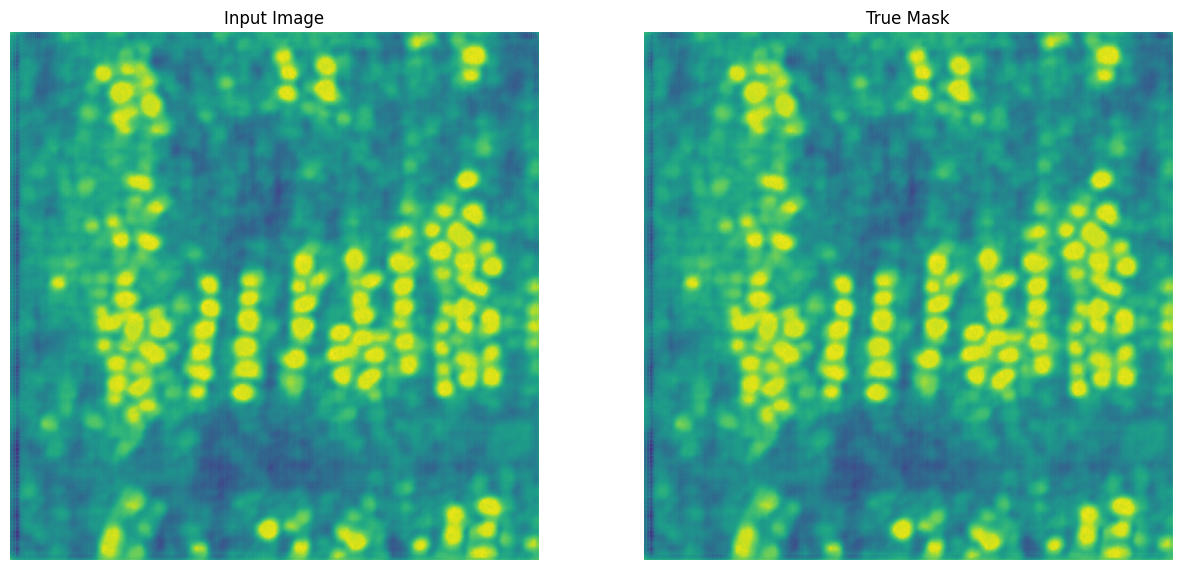

In [165]:
pred0= tf.expand_dims(pred[:, :, 0],-1)
pred1= tf.expand_dims(pred[:, :, 1],-1)

display([pred0, pred1])

In [150]:
predicted_mask = create_mask(unet.predict(sample_image[tf.newaxis, ...]))

1/1 [==============================] - 0s 358ms/step


In [151]:
print(predicted_mask.shape)

(1024, 1024, 1)


In [8]:
def conv_block(inputs=None, n_filters=None, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same',
                  kernel_initializer='he_normal')(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv
    skip_connection = conv
    
    return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=None):
    """
    Convolutional upsampling block
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(n_filters,3,strides=2,padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

In [10]:
def unet_model(input_size=(1024, 1024, 1), n_filters=4, n_classes=2):
    """
    Unet model
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock0 = conv_block(inputs, 4)
    cblock1 = conv_block(cblock0[0], 8)
    cblock2 = conv_block(cblock1[0], 16)
    cblock3 = conv_block(cblock2[0], 32)
    cblock4 = conv_block(cblock3[0], 64)
    cblock5 = conv_block(cblock4[0], 128)
    cblock6 = conv_block(cblock5[0], 256, 0.3) # Include a dropout_prob of 0.3 for this layer
    cblock7 = conv_block(cblock6[0], 512, 0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock8 = upsampling_block(cblock7[0], cblock6[1], n_filters * 64)
    ublock9 = upsampling_block(ublock8, cblock5[1],  128)
    ublock10 = upsampling_block(ublock9, cblock4[1],  64)
    ublock11 = upsampling_block(ublock10, cblock3[1],  32)
    ublock12 = upsampling_block(ublock11, cblock2[1],  16)
    ublock13 = upsampling_block(ublock12, cblock1[1],  8)
    ublock14 = upsampling_block(ublock13, cblock0[1],  n_filters)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock14)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [11]:
img_height = 1024
img_width = 1024
num_channels = 1

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

In [130]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
              #metrics = [tf.keras.metrics.BinaryCrossentropy(name="Binary Crossentropy")])
 

In [16]:
coarse_tuning_counter = 0

In [123]:
unet.load_weights('./checkpoints/segmenter_granules_1024b_unet_10')   

In [ ]:
image_ds = dataset.map(process_path)                      #risky
processed_image_ds = image_ds.map(preprocess)             #risky
VAL_SUBSPLITS = 4
BUFFER_SIZE = 64
BATCH_SIZE = 16
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
if coarse_tuning_counter == 0:
    initial_epochs = 4          # use in general 5
    total_epochs = initial_epochs
    history = unet.fit(train_dataset, epochs=initial_epochs)
else:
    more_epochs = 150
    total_epochs =  total_epochs + more_epochs
    history = unet.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1])
coarse_tuning_counter += 1    

In [46]:
#use only in first run, to define acc
acc = [0.] #+ history.history['accuracy']

loss = [0.] #history.history['loss']

In [137]:
# Save the weights skip in general use
unet.save_weights('./checkpoints/segmenter_granules_1024b_unet_14')
# unet_1 is after 35 epochs at learning rate 1e-3.  loss 0.1596 acc = 0.7522
# unet_2 is after 40 at lr e-3 and 25 at 3e-4 and 2e-5. Loss of 0.1421, acc = 0.7543
# unet_3 is after unet_2 plus 35 at 2e-5. loss 0f 0.1152, acc = 0.7537
# unet_e is after unet_3 plus 50 at e-5. loss of 0.1063, acc 0.7486 ???
# unet_5 ...............plus 150 at e-5. loss of 0.0902, acc 0.7353 
# unet_6 is first try with 1024b.  8 epochs at e-3.  0.1363, 0.7272 but much improved masks!!!
# unet_7 (note notation 1024b) is after _6 and 18 epochs at 2e-4. 0.1935 09020.  worse masks than for 6
# unet_8 after _7 and 30 epochs at 5e-4. 0.1476, 0.8917.  masks improving. I also moved the data augm to the unet.fit cell
# trying to improve data augm.
# unet_9 is 8 after 10 more at 5e-4. 0.1282, 0.8635
# unet_10 is 8 after 50 at e-4. 0.1133 and 0.7601.  Much improvement in predicted masks.
# unet_11 is 10 after 125 at 4e-5. masks and graphs stored in figures.ppt. loss 0.664, acc 0.8328
# unet_12 is 11 after 100 at 3e-5. 0.625, 0.8415. even though numbers are better, the masks look somewhat worse than for unet_11.
# to reproduce them, one would have to load weights of unet_10 and run at 4e-5.
# unet 13 is 10 after 200 epochs at 4e-5.  0.0106, 0.8954.  Accuracy reached a maximum of 0.9154 at epoch 150.
# but loss was 0.0153.  
# unet 14 is 13 plus 150 epochs at 2 e-5. 851 epochs. 0.0136, 0.8932.

In [133]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [134]:
acc += history.history['accuracy']
loss += history.history['loss']


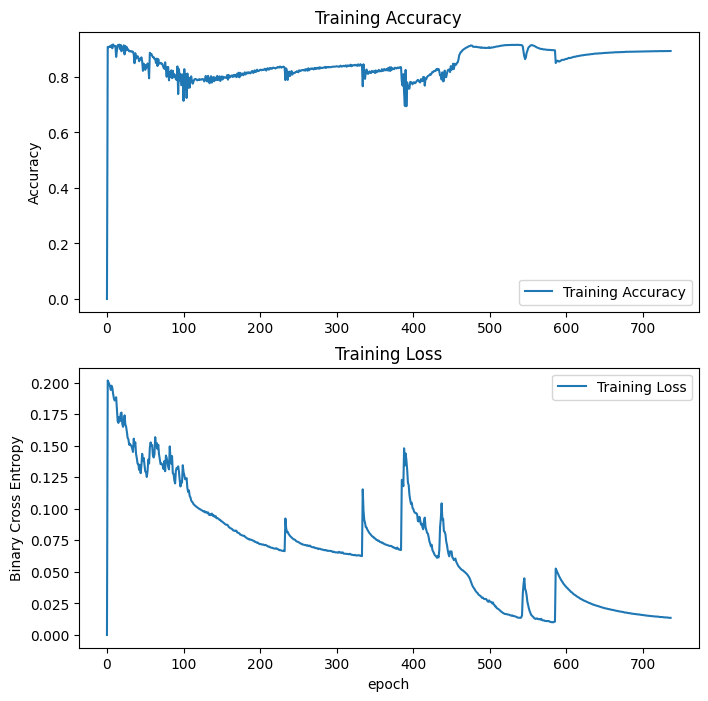

In [135]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
def show_predictions(dataset=None, num=2):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


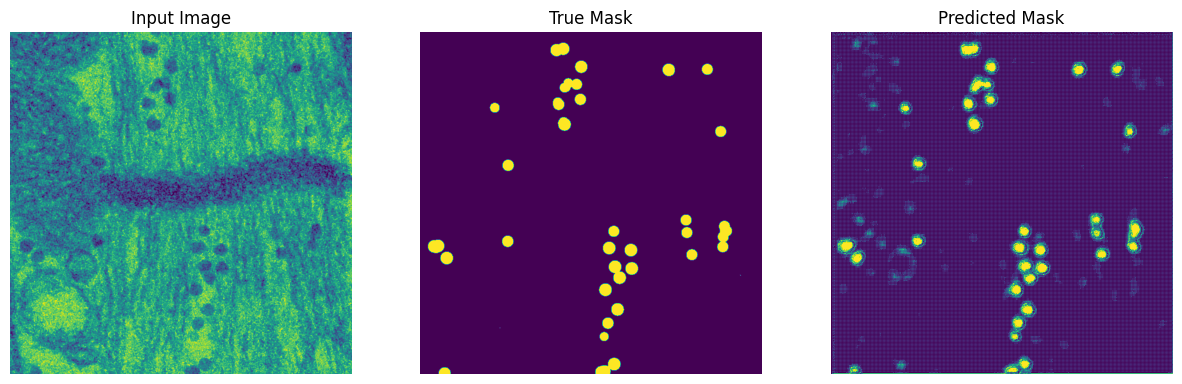

1/1 [==============================] - 3s 3s/step


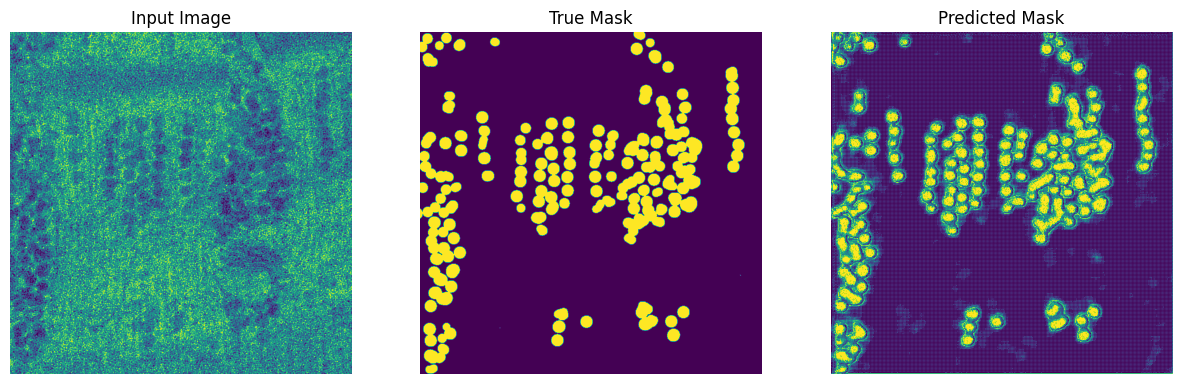

1/1 [==============================] - 2s 2s/step


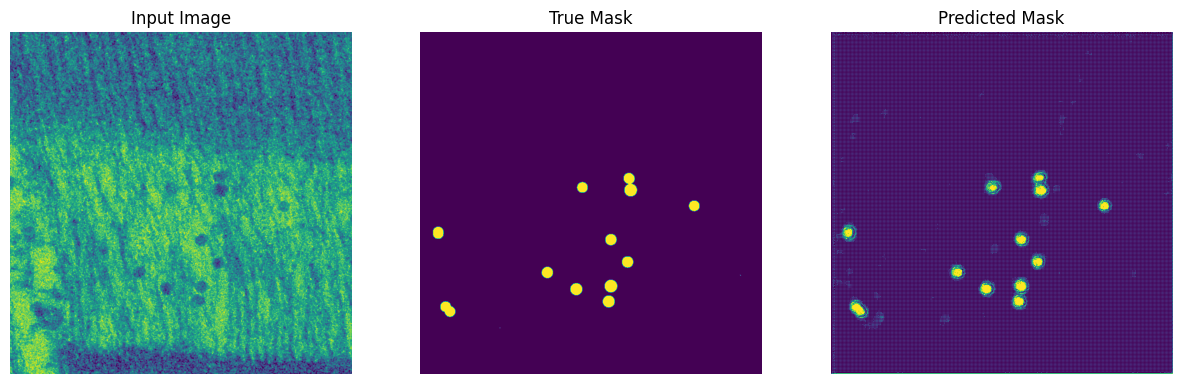

1/1 [==============================] - 3s 3s/step


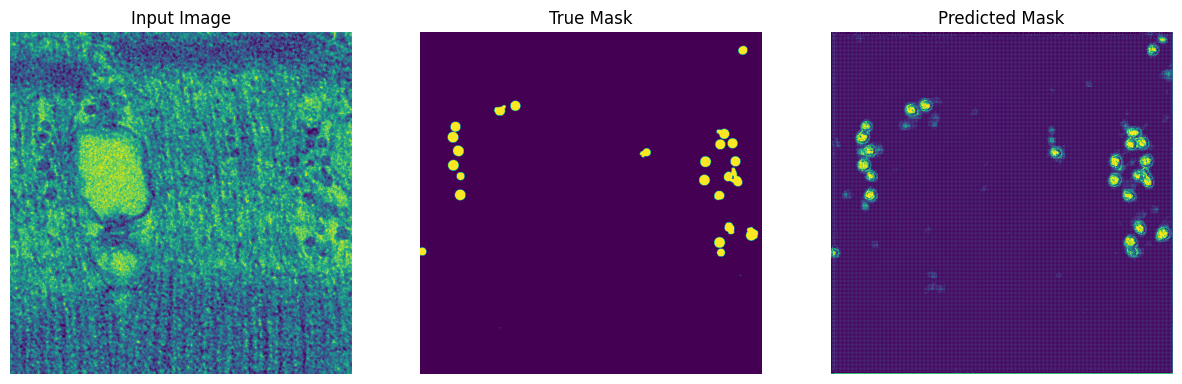

In [166]:
show_predictions(train_dataset, 6)

In [ ]:
# these are general interest cells

In [108]:
pred = create_mask(unet.predict(sample_image[tf.newaxis, ...]))

1/1 [==============================] - 1s 549ms/step


In [110]:
pred.dtype

tf.int64

In [113]:
print(np.max(pred[:,:,0]))

1


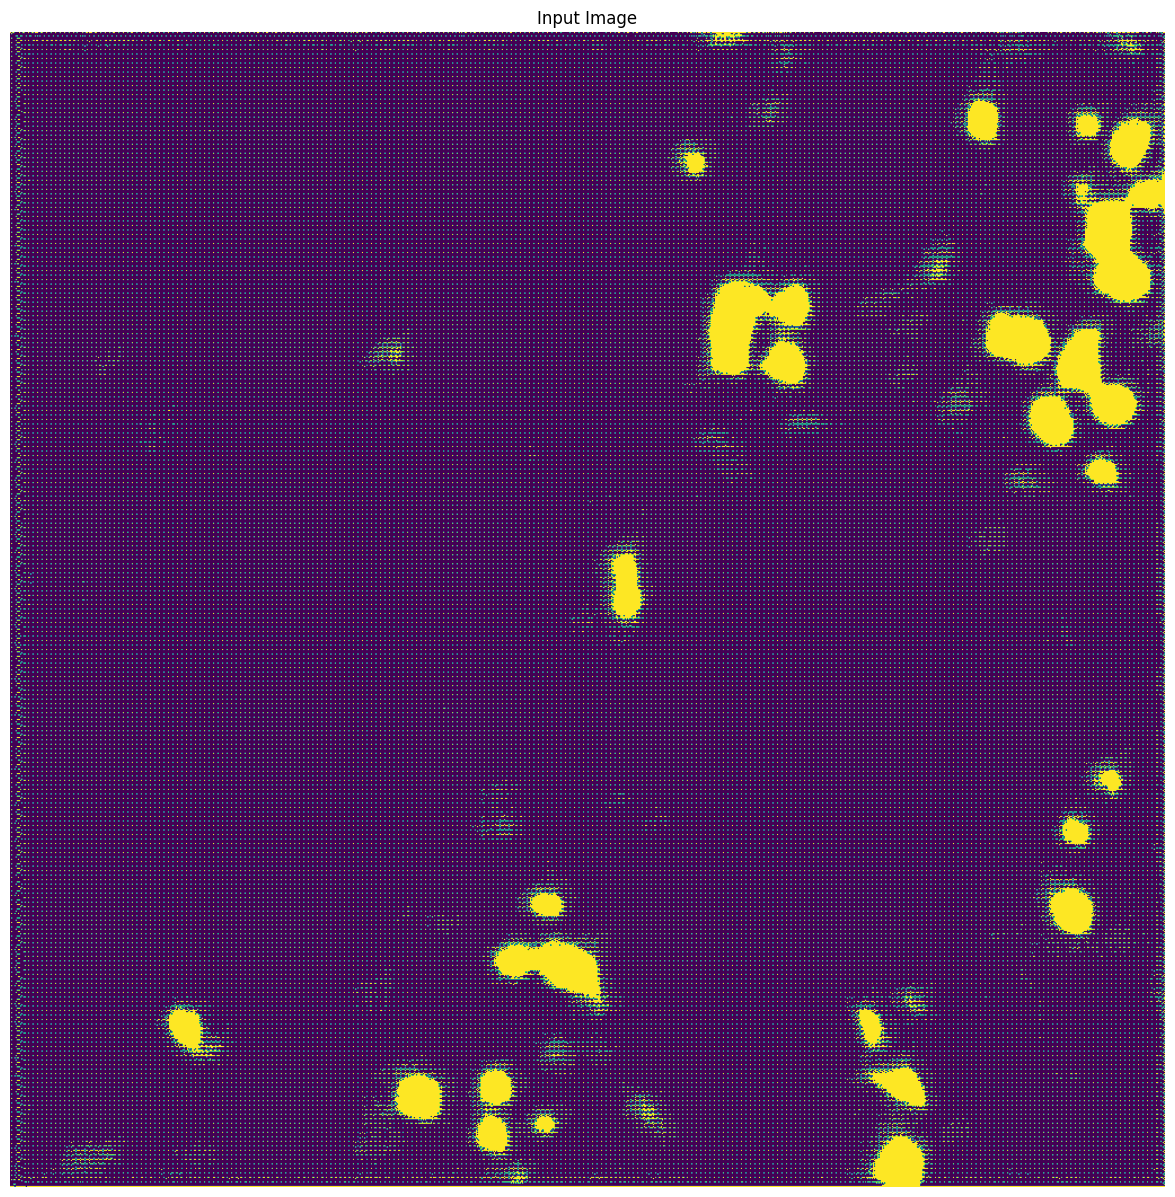

In [114]:
display([pred])

In [66]:
seed = (1,2)  # didn't work
 
def data_augment():
    global seed
    seed = (seed[0] + random.randint(0, 10000), seed[1] + random.randint(0, 10000))

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.image.resize(image, (1024,1024), method='nearest'))
    data_augmentation.add(tf.image.stateless_random_flip_left_right(input_image, seed))
    data_augmentation.add(tf.image.stateless_random_flip_up_down(input_image, seed))
    data_augmentation.add(RandomContrast(0.9))
    data_augmentation.add(tf.image.random_brightness(input_image, 0.25))
    
    return data_augmentation

In [61]:
filename= 'C:/Users/erios/images_3_color_15k_labeled_exp_well/here/image00023.jpg'
img = imageio.imread(filename)

In [66]:
pred_mask[0,:,:,1].shape

(512, 512)

1/1 [==============================] - 1s 1s/step


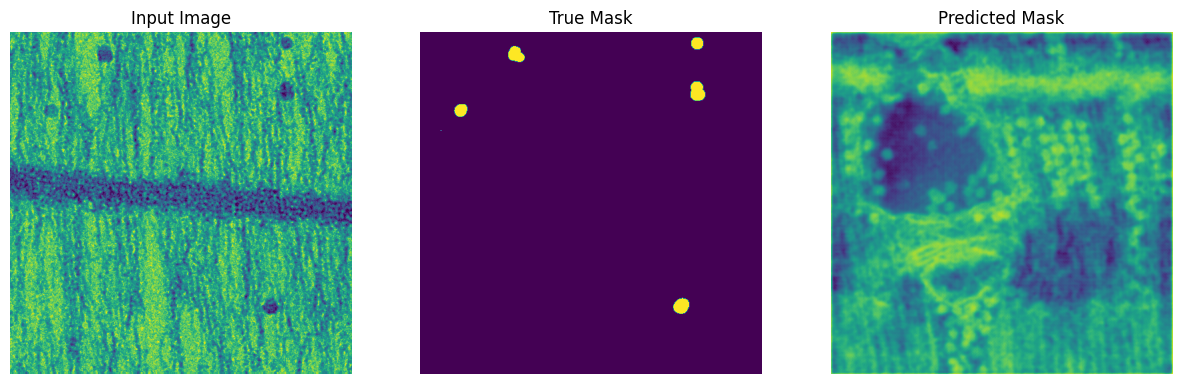

In [78]:
for image, mask in train_dataset.take(1):
    pred_mask = unet.predict(image)
    pred_mask_reform = pred_mask[2,:,:,0]
    pred = tf.expand_dims(pred_mask_reform, -1)
    pred.shape
    display([image[0], mask[0], pred])

In [71]:
pred.shape

TensorShape([512, 512, 1])

In [111]:
prediction = create_mask(unet.predict(sample_image[tf.newaxis, ...]))

1/1 [==============================] - 0s 98ms/step


In [ ]:
#Demo, do not use
filename = 'C:/Users/erios/EM_Images/split_randomized_labels_ping/0050Labeling.png'
file2 = 'C:/Users/erios/EM_Images/split_randomized_renamed_ping20/0050.png'
seed = (2, 3)
img = imageio.imread(filename)
imgt = tf.convert_to_tensor(img) 
imgte = tf.expand_dims(imgt,-1)
print(imgte.shape)
img2 = imageio.imread(file2)
imgt2 = tf.convert_to_tensor(img2) 
imgte2 = tf.expand_dims(imgt2,-1)
print(imgte2.shape)
augmented_image = tf.image.stateless_random_flip_left_right(imgte, (2, 3))
augmented_image2 = tf.image.stateless_random_flip_left_right(imgte2, (2, 3))
plt.imshow(augmented_image)
plt.imshow(augmented_image2)
# this works!

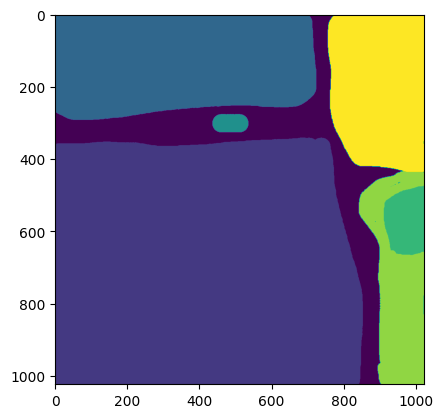

In [33]:
plt.imshow(augmented_image)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(1024, 1024, 1)
(1024, 1024, 1)


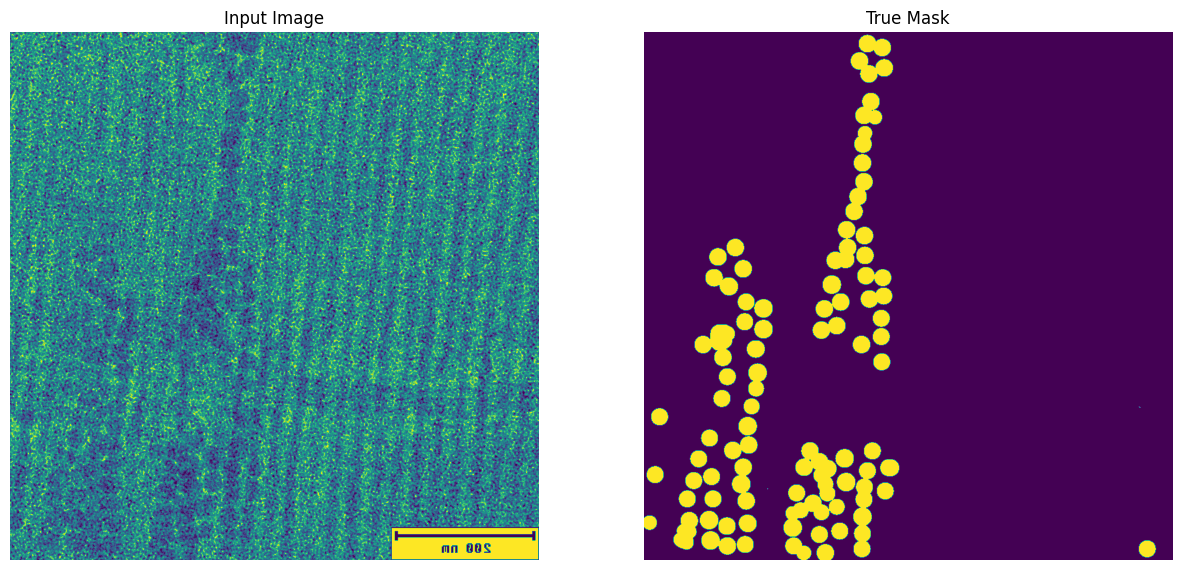

In [91]:
for image, mask in processed_image_ds.take(2):
    sample_image, sample_mask = image, mask
    print(image.shape)
display([sample_image, sample_mask])

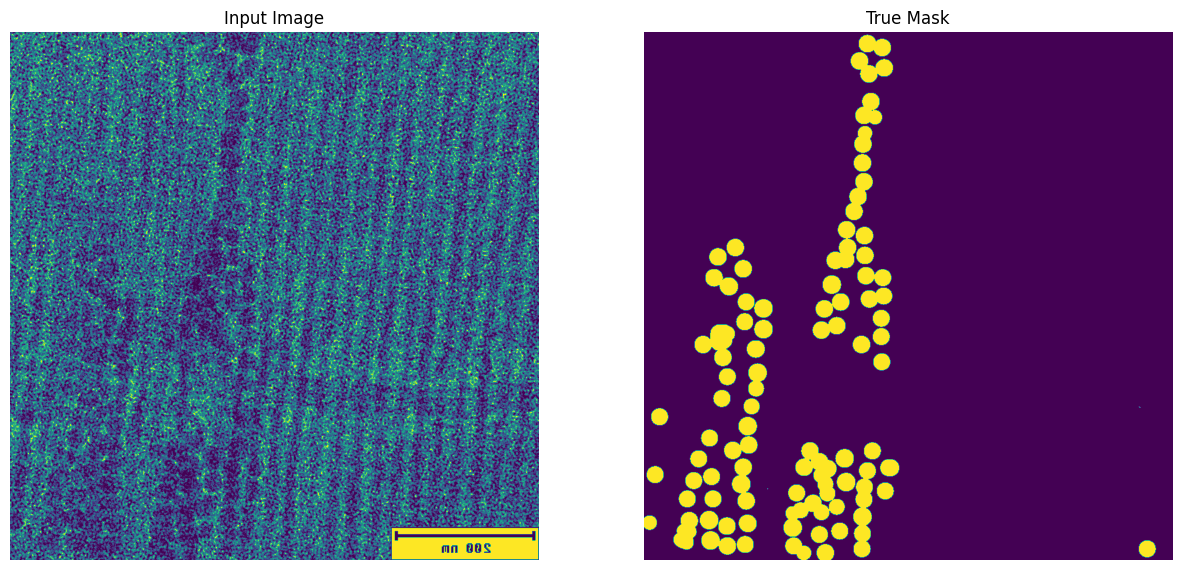

In [122]:
ran = tf.keras.layers.RandomContrast(0.9)
display([ran(sample_image), sample_mask])

In [146]:
# validation only
image_filenames_val = tf.constant(image_list_val)
masks_filenames_val = tf.constant(mask_list_val)

dataset_val = tf.data.Dataset.from_tensor_slices((image_filenames_val, masks_filenames_val))

for image, mask in dataset_val.take(1):
    print(image)
    print(mask)

tf.Tensor(b'C:/Users/erios/EM_Images/split_random_granules_val/0090.png', shape=(), dtype=string)
tf.Tensor(b'C:/Users/erios/EM_Images/split_random_granules_val_labels/0090Labeling.png', shape=(), dtype=string)
